In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import transformers

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 📁 Load data
train_df = pd.read_csv('../data/train.csv', header=None)
test_df = pd.read_csv('../data/test.csv', header=None)

# ⏳ TEMP: Reduce data for faster testing
train_df = train_df.sample(n=2000, random_state=42)
test_df = test_df.sample(n=500, random_state=42)

# 🧾 Assign column names
train_df.columns = ['label', 'title', 'description']
test_df.columns = ['label', 'title', 'description']

# 📝 Combine title + description
train_df['text'] = train_df['title'] + " " + train_df['description']
test_df['text'] = test_df['title'] + " " + test_df['description']

train_df.head()

print(transformers.__version__)



4.54.1


In [2]:
# 🔢 Encode class labels
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

label_encoder.classes_


array(['1', '2', '3', '4'], dtype=object)

In [3]:
# 🔠 Tokenize the text
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_tokens = tokenizer(list(train_df['text']), truncation=True, padding=True)
test_tokens = tokenizer(list(test_df['text']), truncation=True, padding=True)


In [4]:
# 🔗 Build custom PyTorch dataset
class AGNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AGNewsDataset(train_tokens, list(train_df['label_encoded']))
test_dataset = AGNewsDataset(test_tokens, list(test_df['label_encoded']))


In [5]:
# 🧠 Load model and set up Trainer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="../outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="../outputs/logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 🚀 Start training
trainer.train()


c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\multi-class-text-classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.346662,0.896000,0.895361,0.897441,0.896000
2,0.369700,0.472345,0.886000,0.885756,0.897723,0.886000
3,0.369700,0.404967,0.910000,0.910012,0.912627,0.910000


c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\multi-class-text-classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\multi-class-text-classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=750, training_loss=0.2855154724121094, metrics={'train_runtime': 1843.4694, 'train_samples_per_second': 3.255, 'train_steps_per_second': 0.407, 'total_flos': 540237878208000.0, 'train_loss': 0.2855154724121094, 'epoch': 3.0})

c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\multi-class-text-classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           1       0.94      0.86      0.90       118
           2       0.98      0.97      0.97       136
           3       0.89      0.85      0.87       125
           4       0.84      0.95      0.89       121

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



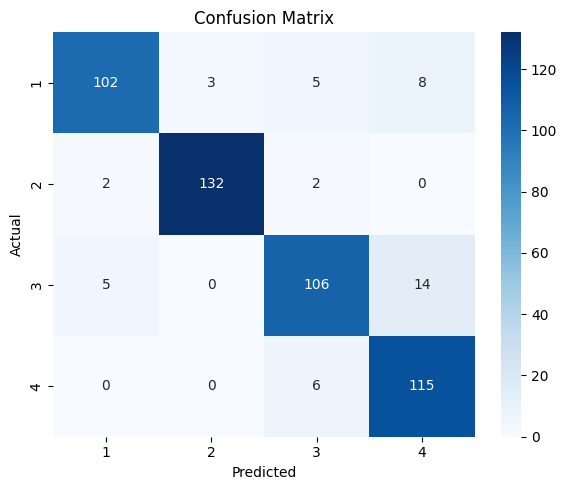

In [7]:
# 📊 Predict and evaluate
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Print classification report
print(classification_report(labels, preds, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("../outputs/confusion_matrix.png")
plt.show()
